# Tests

## Regional masks

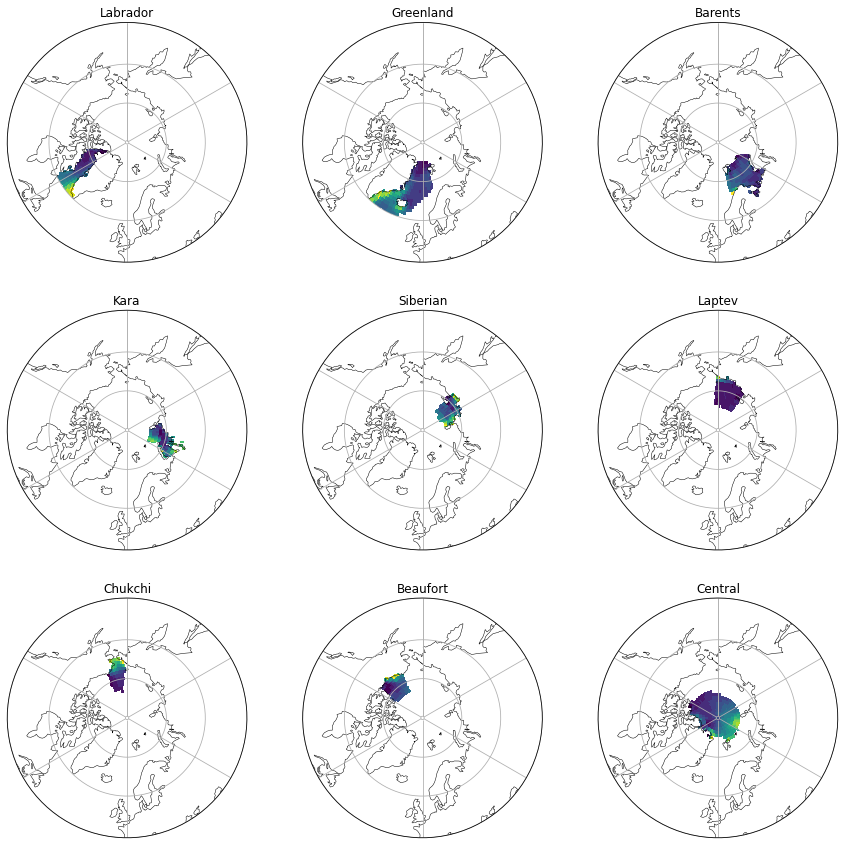

In [1]:
import cartopy.crs as ccrs
import libs.helpers as helpers
import libs.plot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray

import warnings
warnings.filterwarnings('ignore')


def regional(data):
    regions = helpers.nsidc_regions()

    fig, axs = plt.subplots(
        3, 
        3, 
        figsize=(15, 15),
        subplot_kw={ 
            'projection': ccrs.Stereographic(central_latitude=90.0)
        }
    )
    transform = ccrs.PlateCarree()
    axs = axs.flatten()
    
    for i, region in enumerate(regions[1:]):
        data_masked = data.copy()\
            .sel(time=slice('2080-01-01', '2101-01-01'))\
            .where(np.isin(nsidc_mask.values, region['values']))\
            .mean(dim=('time'), skipna=True)
        
        ax = axs[i]
        ax.coastlines(resolution='110m', linewidth=0.5)
        ax.set_extent([-180, 180, 45, 90], transform)
        gl = ax.gridlines()
        gl.ylocator = matplotlib.ticker.LinearLocator(4)

        # Crop to circle
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = matplotlib.path.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        data_masked.plot.pcolormesh(
            add_colorbar=False,
            ax=ax,
            levels=21,
            shading='flat',
            transform=transform
        )
        ax.set_title(region['label'])


path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_LatLon_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask
nsidc_mask = nsidc_mask.roll(x=96, roll_coords=True)

pr = helpers.get_data('ssp585', 'Amon', 'pr', 'r2i1p1f2').pr
pr = pr.where(pr.lat > 60).where(nsidc_mask.values > 0)

regional(pr)